# Investigate simulations with individual soil column per pft  

Inlcuding regridding

(c) Inne Vanderkelen - October 2023

## 1. Settings

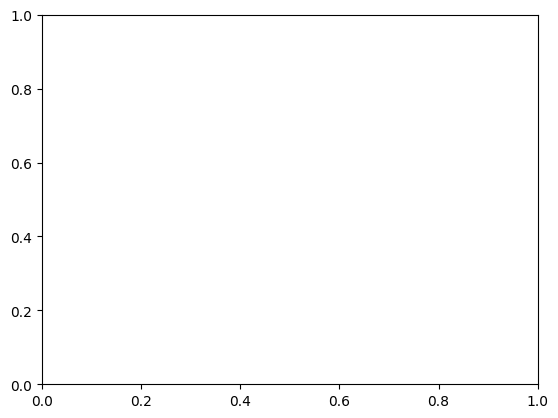

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd
from matplotlib import cm
import geopandas as gpd
# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import  * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'
figdir = '/users/ivanderk/notebooks_4p1000/figures/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenarios = ['high', '4p1000', 'medium']
scenario = '4p1000'
# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 


# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 2 # m 8
figsize = (17,38)

# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [4]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [6]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata('CTL', input_variables, case_ctl)


#ds_input_scen, ds_input_scen, landmask = load_inputdata(scenario, ['ORGANIC', 'PFTDATA_MASK'], case_scen)

In [7]:
def calc_gridcell_means(variables, pft_int, lat_cell, lon_cell, case_ctl, scenarios):
    d_ctl_cell   = {}
    d_scen_cell  = {}
    d_delta_cell = {}


    for variable in variables: 
        print('loading grid cell values of '+variable)



        da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl)
        da_pft_ctl_cell = da_pft_ctl.rename(variable).sel(lat=lat_cell,lon=lon_cell).squeeze().mean('time')

        if 'levgrnd' in da_pft_ctl_cell.dims: 
            da_pft_ctl_cell = da_pft_ctl_cell.rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,len(levsoi_depth)))


        for scenario in scenarios: #calc_gridcell_means 
            # define scenario
            case_scen = case_ctl.replace('CTL',scenario)
            
            if scenario == 'medium': 
                
                case_scen = case_ctl.replace('CTL',scenario).replace('spunup3','spunup2')

            da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen)
            da_pft_scen_cell = da_pft_scen.rename(variable).sel(lat=lat_cell,lon=lon_cell).squeeze().mean('time')

            if 'levgrnd' in da_pft_scen_cell.dims: 

                da_pft_scen_cell = da_pft_scen_cell.rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,len(levsoi_depth)))


            da_delta = (da_pft_scen_cell - da_pft_ctl_cell)

            d_ctl_cell[variable] = da_pft_ctl_cell
            d_scen_cell[variable+'_'+scenario] = da_pft_scen_cell
            d_delta_cell[variable+'_'+scenario] = da_delta

    return d_ctl_cell, d_scen_cell, d_delta_cell
        
        
        

In [8]:
variables = ["H2OSOI", "SMP", "QROOTSINK"]

d_units = {'H2OSOI': 'mm3/mm3', 'SMP' : 'mm', 'QROOTSINK' : 'mm/s'}


## Look at gridcell profiles

### NANYUKI

In [18]:
# select single grid cell to plot
lat_cell = 0.25
lon_cell = 37.25
marker   = 'Laikipia, Kenya'
pft_int = pft_list_crops[0]


scenarios = ['high', 'medium', '4p1000']
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'

d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell, case_ctl, scenarios)
d_xlims = {'H2OSOI': [-0.02,0.2], 'SMP' : [-15000,15000], 'QROOTSINK' : False}


loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


In [19]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
rel_pct_organic = (pct_organic / 130)*100


print('Fraction organic: '+str(np.round(rel_pct_organic.sel(nlevsoi=range(0,5)).mean().values,2)))
print('Fraction clay: '+str(np.round(pct_clay.sel(nlevsoi=range(0,5)).mean().values,2)))
print('Fraction sand: '+str(np.round(pct_sand.sel(nlevsoi=range(0,5)).mean().values,2)))

Fraction organic: 19.62
Fraction clay: 19.4
Fraction sand: 55.8


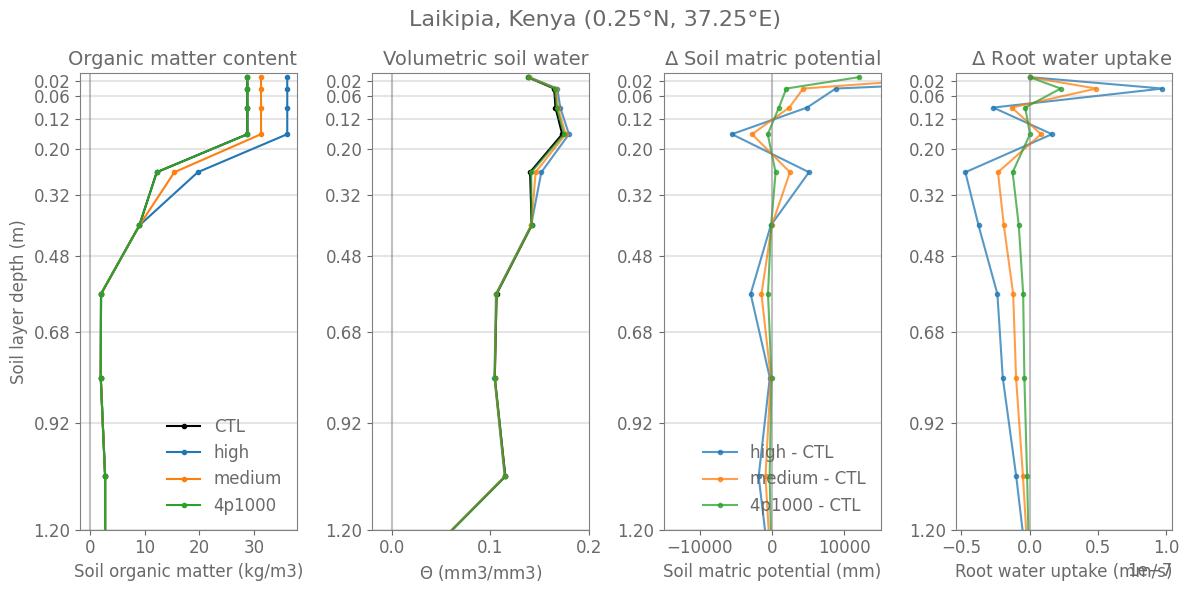

In [20]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
fig, axes = plt.subplots(1,4,figsize=(12,6))
axes = axes.flatten()

ax = axes[0]
ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='CTL')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in scenarios: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.2,0]); 
ax.legend(frameon=False)
ax.set_title('Organic matter content', loc='right' );



# plot absolute profile for soil moisture
ax = axes[1]
variable = 'H2OSOI'

ax.plot(d_ctl_cell[variable], levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.', color='k', label='CTL')
for scenario in scenarios:    

    ax.plot(d_scen_cell[variable+'_'+scenario] , levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.',  label = scenario, alpha=0.75,)

#ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('$\Theta$ (' +str(d_units[variable]+')')); 
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
if not d_xlims[variable] == False: 
    ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.2,0]); 
#ax.legend(frameon=False)
ax.set_title('Volumetric soil water', loc='right' );


# plot delta's

variables_toplot = ['SMP','QROOTSINK']
d_variable_long = {'SMP' : 'Soil matric potential','QROOTSINK' : 'Root water uptake'}
d_variable_long_label = {'SMP' : 'Soil matric\npotential','QROOTSINK' : 'Root water\nuptake'}

for i, variable in enumerate(variables_toplot): 

    ax = axes[i+2]

    for scenario in scenarios:     #'medium',

        ax.plot(d_delta_cell[variable+'_'+scenario] , levsoi[:len(d_delta_cell[variable+'_'+scenario] .levsoi.values)], marker='.',  label =  scenario+' - CTL', alpha=0.75,)

    #ax.set_ylabel('Soil layer depth (m)'); 

    for depth in levsoi_depth:
        ax.axhline(depth,  color='grey', alpha=0.2)
    ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

    if not d_xlims[variable] == False: 
        ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
    ax.set_xlabel(d_variable_long[variable] + ' (' +str(d_units[variable])+')'); 

    ax.set_yticks(levsoi_depth)
    ax.set_ylim([1.2,0]); 
    
    if i ==0: 
        ax.legend(frameon=False, loc='lower right')
    ax.set_title('$\Delta$ '+d_variable_long[variable], loc='right' );

fig.suptitle(marker +' ('+str(lat_cell)+'°N, '+str(lon_cell)+'°E)', fontsize=16)
fig.tight_layout()


fig.savefig(figdir+'gridcell_'+marker+'.png', bbox_inches='tight')

In [11]:
## Laikipia

theta_min = 0.1
theta_max = 0.3
theta_delta = 0.001

om1 = rel_pct_organic.sel(nlevsoi=range(0,10)).mean().values/100
om2=om1
sand1 = pct_sand.sel(nlevsoi=range(0,5)).mean().values
clay1 = pct_clay.sel(nlevsoi=range(0,5)).mean().values

theta = np.arange(theta_min, theta_max+theta_delta*5, theta_delta)
om_frac = np.arange(0.05,1.05,0.05)

bsw1 = 2.91+0.159*clay1
phi1 = 0.489-0.00126*sand1
psi1 = 10.*10**(1.88-0.0131*sand1)

om_watsat         = 0.93
om_b              = 2.7
om_sucsat         = 10.3

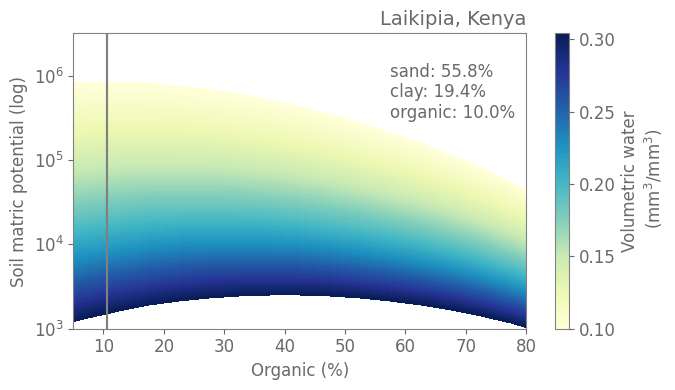

In [12]:
phi =  ( (1. - om_frac) * phi1 + om_watsat*om_frac )
bsw =  ( (1.-om_frac) * bsw1 + om_frac*om_b )
psi =  ( (1.-om_frac) * psi1 + om_sucsat*om_frac )


psia = np.empty([len(om_frac), len(theta)])
# show saturated matric potential
for n in range(0,len(theta)): 
    psia[:,n] = psi*(theta[n]/phi)**(-bsw)

X, Y = np.meshgrid(theta,om_frac)
Z = psia

fig = plt.figure(figsize=(7,4))

# set up the axes for the first plot
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(Y, np.log10(Z), X,  cmap=cm.YlGnBu)
ax.axvline(om1, color='grey')
ax.axvline(om2, color='grey')
ax.set_xlabel('Organic (%)')
ax.set_ylabel('Soil matric potential (log)')
ax.set_xlim(0.05,0.40)
ax.set_xticks(np.arange(0.1,0.9,0.1))
ax.set_xticklabels([10,20,30,40,50,60,70, 80])

ax.set_yticks([3,4,5,6,7])
ax.set_yticklabels(['10$^3$', '10$^4$','10$^5$','10$^6$','10$^7$',])
ax.set_ylim(3,6.5)

ax.set_title(marker, loc='right');
fig.colorbar(mesh, label='Volumetric water\n (mm$^3$/mm$^3$)')
fig.tight_layout()
textures = 'sand: '+str(sand1)+'%\nclay: '+str(clay1) +'%\norganic: '+str(np.round(om1,1)*100)+'%'
ax.text(x = 0.7, y = 0.8, s=textures,  transform = ax.transAxes,      horizontalalignment='left',
     verticalalignment='center',size=12);
fig.savefig(figdir+'sensitivity_'+marker+'.png', bbox_inches='tight')

## Indore (high clay)

In [12]:
# select single grid cell to plot
lat_cell = 22.75
lon_cell = 75.75
marker   = 'Indore, India'
pft_int = pft_list_crops[0]

In [13]:

# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
rel_pct_organic = (pct_organic / 130)*100


print('Fraction organic: '+str(np.round(rel_pct_organic.sel(nlevsoi=range(0,5)).mean().values,2)))
print('Fraction clay: '+str(np.round(pct_clay.sel(nlevsoi=range(0,5)).mean().values,2)))
print('Fraction sand: '+str(np.round(pct_sand.sel(nlevsoi=range(0,5)).mean().values,2)))

Fraction organic: 29.56
Fraction clay: 52.8
Fraction sand: 20.6


In [14]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell, case_ctl, scenarios)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


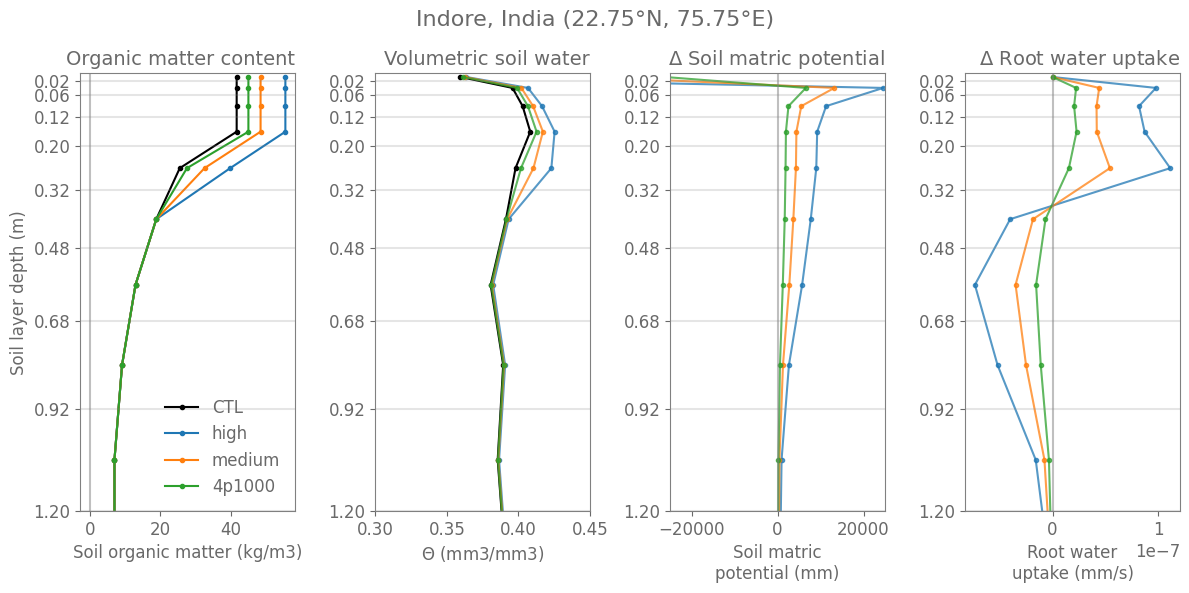

In [17]:
d_xlims = {'H2OSOI': [0.3,0.45], 'SMP' :[-2.5e4,2.5e4],  'QROOTSINK' : False}


# plot difference profiles for water content, soil matric potential and root water uptake. 
fig, axes = plt.subplots(1,4,figsize=(12,6))
axes = axes.flatten()

ax = axes[0]
ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='CTL')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in scenarios: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.2,0]); 
ax.legend(frameon=False)
ax.set_title('Organic matter content', loc='right' );



# plot absolute profile for soil moisture
ax = axes[1]
variable = 'H2OSOI'

ax.plot(d_ctl_cell[variable], levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.', color='k', label='CTL')
for scenario in scenarios:    

    ax.plot(d_scen_cell[variable+'_'+scenario] , levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.',  label = scenario, alpha=0.75,)

#ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('$\Theta$ (' +str(d_units[variable]+')')); 
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
if not d_xlims[variable] == False: 
    ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.2,0]); 
#ax.legend(frameon=False)
ax.set_title('Volumetric soil water', loc='right' );


# plot delta's

variables_toplot = ['SMP','QROOTSINK']
d_variable_long = {'SMP' : 'Soil matric potential','QROOTSINK' : 'Root water uptake'}
d_variable_long_label = {'SMP' : 'Soil matric\npotential','QROOTSINK' : 'Root water\nuptake'}

for i, variable in enumerate(variables_toplot): 

    ax = axes[i+2]

    for scenario in scenarios:     #'medium',

        ax.plot(d_delta_cell[variable+'_'+scenario] , levsoi[:len(d_delta_cell[variable+'_'+scenario] .levsoi.values)], marker='.',  label = scenario, alpha=0.75,)

    #ax.set_ylabel('Soil layer depth (m)'); 

    for depth in levsoi_depth:
        ax.axhline(depth,  color='grey', alpha=0.2)
    ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

    if not d_xlims[variable] == False: 
        ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
    ax.set_xlabel(d_variable_long_label[variable] + ' (' +str(d_units[variable])+')'); 

    ax.set_yticks(levsoi_depth)
    ax.set_ylim([1.2,0]); 
    #ax.legend(frameon=False, loc='lower right')
    ax.set_title('$\Delta$ '+d_variable_long[variable], loc='right' );

fig.suptitle(marker +' ('+str(lat_cell)+'°N, '+str(lon_cell)+'°E)', fontsize=16)
fig.tight_layout()

fig.savefig(figdir+'gridcell_'+marker+'.png', bbox_inches='tight')

In [17]:
## INDORE

theta_min = 0.3
theta_max = 0.4
theta_delta = 0.001

om1 = rel_pct_organic.sel(nlevsoi=range(0,5)).mean().values/100
om2=om1
sand1 = pct_sand.sel(nlevsoi=range(0,5)).mean().values
clay1 = pct_clay.sel(nlevsoi=range(0,5)).mean().values



theta = np.arange(theta_min, theta_max+theta_delta*5, theta_delta)
om_frac = np.arange(0.1,1.05,0.05)



bsw1 = 2.91+0.159*clay1
phi1 = 0.489-0.00126*sand1
psi1 = 10.*10**(1.88-0.0131*sand1)



om_watsat         = 0.93
om_b              = 2.7
om_sucsat         = 10.3

cols = ['b','g','r','y']

ncol = 1
nrow = 2



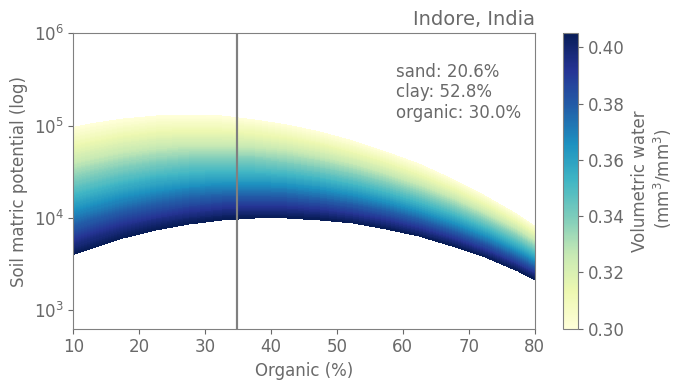

In [18]:
phi =  ( (1. - om_frac) * phi1 + om_watsat*om_frac )
bsw =  ( (1.-om_frac) * bsw1 + om_frac*om_b )
psi =  ( (1.-om_frac) * psi1 + om_sucsat*om_frac )


psia = np.empty([len(om_frac), len(theta)])
# show saturated matric potential
for n in range(0,len(theta)): 
    psia[:,n] = psi*(theta[n]/phi)**(-bsw)

X, Y = np.meshgrid(theta,om_frac)
Z = psia

fig = plt.figure(figsize=(7,4))

# set up the axes for the first plot
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(Y, np.log10(Z), X,  cmap=cm.YlGnBu)
ax.axvline(om1, color='grey')
ax.axvline(om2, color='grey')
ax.set_xlabel('Organic (%)')
ax.set_ylabel('Soil matric potential (log)')
ax.set_xlim(0.1,0.80)
ax.set_xticks(np.arange(0.1,0.9,0.1))
ax.set_xticklabels([10,20,30,40,50,60,70,80])

ax.set_ylim(2.8,5.5)
ax.set_yticks([3,4,5,6])
ax.set_yticklabels(['10$^3$', '10$^4$','10$^5$','10$^6$'])

ax.set_title(marker, loc='right');
fig.colorbar(mesh, label='Volumetric water\n (mm$^3$/mm$^3$)')
fig.tight_layout()
textures = 'sand: '+str(sand1)+'%\nclay: '+str(clay1) +'%\norganic: '+str(np.round(om1,1)*100)+'%'
ax.text(x = 0.7, y = 0.8, s=textures,  transform = ax.transAxes,      horizontalalignment='left',
     verticalalignment='center',size=12);


fig.savefig(figdir+'sensitivity_'+marker+'.png', bbox_inches='tight')

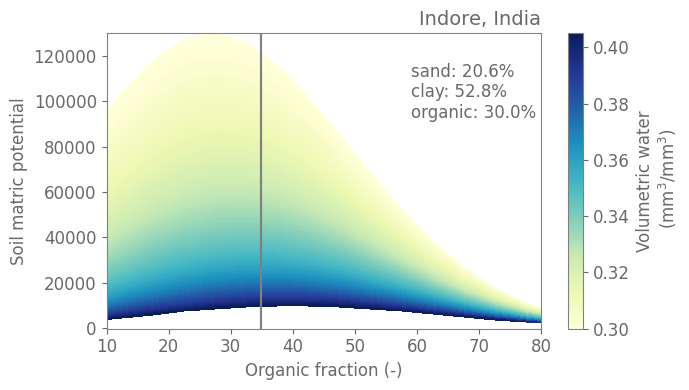

In [19]:
phi =  ( (1. - om_frac) * phi1 + om_watsat*om_frac )
bsw =  ( (1.-om_frac) * bsw1 + om_frac*om_b )
psi =  ( (1.-om_frac) * psi1 + om_sucsat*om_frac )


psia = np.empty([len(om_frac), len(theta)])
# show saturated matric potential
for n in range(0,len(theta)): 
    psia[:,n] = psi*(theta[n]/phi)**(-bsw)

X, Y = np.meshgrid(theta,om_frac)
Z = psia

fig = plt.figure(figsize=(7,4))

# set up the axes for the first plot
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(Y, Z, X,  cmap=cm.YlGnBu)
ax.axvline(om1, color='grey')
ax.axvline(om2, color='grey')
ax.set_xlabel('Organic fraction (-)')
ax.set_ylabel('Soil matric potential')
ax.set_xlim(0.1,0.80)
ax.set_xticks(np.arange(0.1,0.9,0.1))
ax.set_xticklabels([10,20,30,40,50,60,70,80])
ax.set_title(marker, loc='right');
fig.colorbar(mesh, label='Volumetric water\n (mm$^3$/mm$^3$)')
fig.tight_layout()
textures = 'sand: '+str(sand1)+'%\nclay: '+str(clay1) +'%\norganic: '+str(np.round(om1,1)*100)+'%'
ax.text(x = 0.7, y = 0.8, s=textures,  transform = ax.transAxes,      horizontalalignment='left',
     verticalalignment='center',size=12);
